# マルチメディア

## PILのイメージモジュールに関して

**参考URL**
[ドキュメント](https://pillow.readthedocs.io/en/stable/reference/Image.html)
[侍エンジニア](https://www.sejuku.net/blog/62599)

いろいろできる画像ライブラリ　今回はjpegのインプットのみに使用

### attributes 

* filename
* format
* mode
* size
* width
* height 
* palette
* info



## 関連ライブラリのインポート 

In [1]:
from PIL import Image
import numpy as np
# pathをよしなにしてくれるライブラリ
import pathlib
# 画像表示するだけ
from IPython.display import display
# sort に必要
from operator import attrgetter
# 時間測定
import time

# debugger
from IPython.core.debugger import set_trace

# 外部ファイルのインポート
# from mosaic import Mosaic

### 一時的にMosacをおく

In [2]:
import numpy as np

class Mosaic:
    
    MAXDOUBLE =  1.79769313486231e+308
    
    
    def convert_image_to_array(self, pli_img, height, width):
        img_pixels = []
        for y in range(height):
            for x in range(width):
                # getpixel((x,y))で左からx番目,上からy番目のピクセルの色を取得し、img_pixelsに追加する
                img_pixels.append(pli_img.getpixel((x,y)))
        # あとで計算しやすいようにnumpyのarrayに変換しておく
        return np.array(img_pixels)
    
    @classmethod
    def mosaic(self, image1, image2, r):
        
        #image1_pixels = convert_image_to_array(image1)
        #image2_pixels = convert_image_to_array(image2)

        # 画像のサイズを1/5倍に変更する
        resized_image1 = self.__resize_image(
            image      = image1,
            to_width   = int(image1.width/5), 
            to_height  = int(image1.height/5)
        )
        
        resized_image2 = self.__resize_image(
            image      = image2,
            to_width   = int(image2.width/5), 
            to_height  = int(image2.height/5)
        )
        
        
        # 縮小した画像で、画像が最も重なるとこのパラメタを概算
        j_min1, i_min1, t_min1 = self.__get_min_params(
            image1 = resized_image1,
            image2 = resized_image2,
            xmin   = 2, 
            xmax   = int(image1.width / 5 - 3),
            ymin   = 2,
            ymax   = int(image1.height / 5 - 3),
            tmin   = -15.0,
            tmax   = 15.0,
            tstep  = 2.0
        )
        
        print("j_min1:{}, i_min1:{}, t_min:{}".format(j_min1, i_min1, t_min1))
        
        # 元の画像でパラメタを計算
        j_min2, i_min2, t_min2 = self.__get_min_params(
            image1 = image1,
            image2 = image2,
            xmin   = (j_min1 - 1) * 5, 
            xmax   = (j_min1 + 1) * 5 - 1,
            ymin   = (i_min1 - 1) * 5,
            ymax   = (i_min1 + 1) * 5 - 1,
            tmin   = t_min1 - 1.0,
            tmax   = t_min1 + 1.0,
            tstep  = 1.0
        )
        
        # TODO double型に変換
        return j_min2, i_min2, t_min2, r
        
    @classmethod
    def __resize_image(self, image, to_width, to_height):
        """画像の大きさを変更し、返します。
        
        Args：
            image (PLI Image): 大きさを変更する画像
            to_width (int):  画像の大きさ(横：水平方向)
            to_height (int): 画像の大きさ(縦：垂直方向
           
        Returns:
            res_image (PLI Image): サイズ変更した画像
        
        """
        
        res_image = Image.new("RGB", (to_width, to_height))
    
        
        #元の画像と新しい画像の大きさの比を計算
        step_x = int(image.width  / to_width)
        step_y = int(image.height / to_height)
        
        # ピクセルのコピー
        for i in range(to_height):
            for j in range(to_width):
                r = g = b = 0
                count = 0
                for k in range(step_y*i, step_y*(i+1)-1):
                    for l in range(step_x*j, step_x*(j+1)-1):
                        if( k >= image.height or l >= image.width):
                            continue
                        count += 1
                            
                        r += image.getpixel((l,k))[0]
                        g += image.getpixel((l,k))[1]
                        b += image.getpixel((l,k))[2]
                res_image.putpixel((j, i), (int(r /count), int(g /count), int(b /count)))
        
        return res_image
    
    @classmethod
    def __get_min_params(self, image1, image2, xmin, xmax, ymin, ymax, tmin, tmax, tstep):
        """二つの画像が最も一致するときの移動量(右方向、下方向)と回転角を総当たりで計算する。
        
        一致の基準はR、G、Bの各チャンネルの二乗誤差である。
  
        Args：
            img1 (PLI Image): 比較する画像1
            img2 (PLI Image): 比較する画像2
            xmin (int): 横方向の探索範囲
            xmax (int): 横方向の探索範囲
            ymin (int): 縦方向の探索範囲
            ymax (int): 縦方向の探索範囲
            tmin (int): 回転角の探索範囲
            tmax (int): 回転角の探索範囲
            tstep (int): 回転角の更新量(探索精度)
           
        Returns:
            dx (int): 右方向の移動量（単位はピクセル）
            dy (int): 下方向の移動量（単位はピクセル）
            dt (int): 反時計回りの回転角（単位は度)
        """
        
        min_value = self.MAXDOUBLE
        dx, dy = 0, 0
        dt = 0.0
        
        #for t in np.arange(tmin, tmax + 1, tstep):
        #    s1 = np.sin(t * np.pi / 180.0)
        #    c1 = np.cos(t * np.pi / 180.0)
        
        t = 0.0
        s1 = np.sin(t * np.pi / 180.0)
        c1 = np.cos(t * np.pi / 180.0)
            
        for y in range(ymin, ymax + 1):
            for x in range(xmin, xmax + 1):
                total = 0
                count = 0
                
                
                for i in range(0, image2.height):
                    for j in range(0, image2.width):
                        
                        
                        
                        #画像2を回転したときのピクセル位置
                        u = int((s1 * i + c1 * j) + x + 0.5)
                        v = int((c1 * i - s1 * j) + y + 0.5)
                
                        
                       
                        # 画像が重ならない部分は誤差を計算しない
                        if(any([u < 0, u >= image1.width, v < 0, v >= image1.height])):
                            continue
                            
                            
                       
                        
                        # 二乗誤差の計算
                        tmp = image1.getpixel((u,v))[0] - image2.getpixel((j,i))[0]
                        total += tmp**2
                        tmp = image1.getpixel((u,v))[1] - image2.getpixel((j,i))[1]
                        total += tmp**2
                        tmp = image1.getpixel((u,v))[2] - image2.getpixel((j,i))[2]
                        total += tmp**2
                        
                        count += 1
                
                if(count <= 0):
                    continue
                # 平均二乗誤差の計算
                ave = float(total) / count
                
                # 平均二乗誤差が最小値より小さい場合はパラメタの更新
                if(min_value > ave):
                    min_value = ave
                    dx = x
                    dy = y
                    dt = t
                
        return (dx, dy, dt)
                            

            

In [3]:
import numpy as np
from PIL import Image

class Cut:
    x  = 0
    y1 = 0
    y2 = 0
    
    def __init__(self, x, y1, y2):
        self.x  = x
        self.y1 = y1
        self.y2 = y2

class Pnm:
    
    
    @classmethod
    def construct_image(self, image1, image2, dx, dy, dt, r):
        
        # TODO rはとりあえず後回し
        resized_image = image2
        
        # 回転角を度からラジアンに変換
        dt = dt * np.pi / 180.0
        
        s1 = np.sin(dt)
        c1 = np.cos(dt)
        
        # 合成画像を含む最小の矩形を計算(image1の左上が座標の原点)
        
        
        # 上
        top = 0
        top = np.min([top, int(dy)])
        top = np.min([top, int(dy - resized_image.width * s1)])
        top = np.min([top, int(dy - resized_image.width * s1 + resized_image.height * c1)])
        top = np.min([top, int(dy + resized_image.height * c1)])
            
            
        # 下
        bottom = image1.height - 1
        bottom = np.max([bottom, int(np.ceil(dy) - 1)])
        bottom = np.max([bottom, int(np.ceil(dy - resized_image.width * s1) - 1)])
        bottom = np.max([bottom, int(np.ceil(dy - resized_image.width * s1 + resized_image.height * c1) - 1)])
        bottom = np.max([bottom, int(np.ceil(dy - resized_image.width * c1) - 1)])
        
           
        # 左
        left = 0
        left = np.min([left, int(dx)])
        left = np.min([left, int(dx + resized_image.width * c1)])
        left = np.min([left, int(dx + resized_image.width * c1 + resized_image.height * s1)])
        left = np.min([left, int(dx + resized_image.height * s1)])
        
        
        # 右
        right = image1.width - 1
        right = np.max([right, int(np.ceil(dx) - 1)])
        right = np.max([right, int(np.ceil(dx + resized_image.width * c1) - 1)])
        right = np.max([right, int(np.ceil(dx + resized_image.width * c1 + resized_image.height * s1) - 1)])
        right = np.max([right, int(np.ceil(dx + resized_image.height * s1) - 1)])
           
        # 合成画像の大きさを計算
        width  = right - left + 1
        height = bottom - top + 1
        
        image = Image.new("RGB", (width, height))
           
        # 合成画像の初期化(白で埋める)
        for i in range(height):
            for j in range(width):
                image.putpixel((j,i), (100, 100, 100))
           
        x1 = (- dx + left) * c1 - (- dy + top) * s1
        y1 = (- dx + left) * s1 + (- dy + top) * c1
        
           
        for i in range(image.height):
            for j in range(image.width):
                x = int((j - dx + left) * c1 - (i - dy + top) * s1)
                y = int((j - dx + left) * s1 + (i - dy + top) * c1)
           
                if(all([x >= 0, x < resized_image.width, y >= 0, y < resized_image.height])):
                    # image.putpixel((j,i), resized_image.getpixel((x,y)))
                   
                    # resized_imageを合成画像に書き出す
                    r,g,b = self.__get_pixel(resized_image, j, i, x1, y1, s1, c1)
                    image.putpixel((j, i), (r,g,b))
           
                    # image1の画像領域の場合、合成画像とimage1の平均で上書きする
                    if(all([i + top >= 0, i + top < image1.height, j + left >= 0, j + left < image1.width])):
                        r = (image.getpixel((j,i))[0] + image.getpixel((int(j + left), int(i + top)))[0]) / 2
                        g = (image.getpixel((j,i))[1] + image.getpixel((int(j + left), int(i + top)))[1]) / 2
                        b = (image.getpixel((j,i))[2] + image.getpixel((int(j + left), int(i + top)))[2]) / 2
                        image.putpixel((j,i), (int(r), int(g), int(b)))
                elif(all([i + top >= 0, i + top < image1.height, j + left >= 0, j + left < image1.width])):

                    tmp = (int(j+left), int(i+top))
                    image.putpixel((j,i), image1.getpixel(tmp))         
           
        return image
    

    @classmethod
    def __get_pixel(self, image, u, v, x1, y1, s1, c1):
        
        c, cut = self.__make_cut(u, v, x1, y1, s1, c1)
    
        
        s_sum = 0.0
        r = g = b = 0.0
        for i in range(1, c):
            
            
            ymin = cut[i-1].y1 if cut[i-1].y1 < cut[i].y1 else cut[i].y1
            ymax = cut[i-1].y2 if cut[i-1].y2 < cut[i].y2 else cut[i].y2
            
            yy = int(ymax)
            xx = int(cut[i-1].x)
            
            for yy in range(int(ymax), int(ymin) - 1,-1):
                
                
                if(cut[i-1].y1 > yy+1 or cut[i-1].y2 < yy):
                    continue
                if(cut[i].y1 > yy+1 or cut[i].y2 < yy):
                    continue
                t1 = cut[i-1].y1 if cut[i-1].y1 > yy   else yy
                t2 = cut[i-1].y2 if cut[i-1].y2 < yy+1 else yy+1
                t3 = cut[i].y1   if cut[i].y1   > yy   else yy
                t4 = cut[i].y2   if cut[i].y2   < yy+1 else yy+1
                s  = (t2 - t1 + t4 - t3) * (cut[i].x - cut[i-1].x) / 2.0
                
                s_sum += s
                
                if(any([cut[i-1].x < 0, cut[i].x > image.width, yy < 0, yy >= image.height])):
                    r += s * 255.0
                    g += s * 255.0
                    b += s * 255.0
                    
                else:
                    
                    r += s * image.getpixel((xx, yy))[0]
                    g += s * image.getpixel((xx, yy))[1]
                    b += s * image.getpixel((xx, yy))[2]

        r = np.min([r, 255.0])
        g = np.min([g, 255.0])
        b = np.min([b, 255.0])
        
        return int(r), int(g), int(b)
        
    
    @classmethod
    def __make_cut(self, u, v, x1, y1, s1, c1):
        
        cuts = []

        k = [0]*4
        xx = yy1 = yy2 = 0
        ind = [(0, 0), (1, 0), (1,1), (0,1)]

        X = [c1 * (u + ind[i][0]) - s1 * (v + ind[i][1]) + x1 for i in range(4)]
        Y = [s1 * (u + ind[i][0]) + c1 * (v + ind[i][1]) + y1 for i in range(4)]
            
            
        if(X[0] == X[3]):
            cut = Cut(X[0], Y[0], Y[3])
            cuts.append(cut)
            cut = Cut(X[1], Y[1], Y[2])
            cuts.append(cut)
        elif(X[0] < X[3]):
            cut = Cut(X[0], Y[0], Y[0])
            cuts.append(cut)
            cut = Cut(X[2], Y[2], Y[2])
            cuts.append(cut)
            if(X[1] == X[3]):
                cut = Cut(X[1], Y[1], Y[3])
                cuts.append(cut)
            elif(X[1] > X[3]):
                cut = Cut(X[1], Y[1], (X[1]-X[2]) * (Y[3]-Y[2]) / (X[3]-X[2]) + Y[2])
                cuts.append(cut)
                cut = Cut(X[3], Y[3], (X[3]-X[0]) * (Y[1]-Y[0]) / (X[1]-X[0] + Y[0]))
                cuts.append(cut)
            else:
                cut = Cut(X[1], Y[1], (X[1]-X[0]) * (Y[3]-Y[0]) / (X[3]-X[0]) + Y[0])
                cuts.append(cut)
                cut = Cut(X[3], Y[3], (X[3]-X[1]) * (Y[2]-Y[1]) / (X[2]-X[1]) + Y[1])
                cuts.append(cut)
                
        else:
            cut = Cut(X[3], Y[3], Y[3])
            cuts.append(cut)
            cut = Cut(X[1], Y[1], Y[1])
            cuts.append(cut)
            
            if(X[0] == X[2]):
                cut = Cut(X[0], Y[0], Y[2])
                cuts.append(cut)
                
            elif(X[0] > X[2]):
                cut = Cut(X[0], Y[0], (X[0]-X[1]) * (Y[2]-Y[1]) / (X[2]-X[1]) + Y[1] )
                cuts.append(cut)
                cut = Cut(X[2], Y[2], (X[2]-X[0]) * (Y[3]-Y[0]) / (X[3]-X[0]) + Y[0] )
                cuts.append(cut)
    
            else:
                cut = Cut(X[0], Y[0], (X[0]-X[2]) * (Y[3]-Y[2]) / (X[3]-X[2]) + Y[2] )
                cuts.append(cut)
                cut = Cut(X[2], Y[2], (X[2]-X[0]) * (Y[1]-Y[0]) / (X[1]-X[0]) + Y[0] )
                cuts.append(cut)
                        
                
        for i in range(4):
            for j in range(4):
                k[j] = (i +  j) % 4
                
            
            if(Y[k[3]] == Y[k[0]]):
                continue
                
            yy1 = Y[k[3]] if Y[k[3]] > Y[k[0]] else Y[k[0]]
            xx = (yy1 - Y[k[0]]) * (X[k[3]] - X[k[0]]) / (Y[k[3]] - Y[k[0]]) + X[k[0]]
            
            flag = 0
            
            for j in range(len(cuts)):
                if(xx == cuts[j].x):
                    flag =1
                    
                    break
                    
            if(flag):
                continue
                
            for j in range(3):
                if((X[k[j]] < xx and xx < X[k[j+1]]) or (X[k[j+1]] < xx and xx < X[k[j]])):
                    yy2 = (xx - X[k[j]]) * (Y[k[j+1]] - Y[k[j]]) / (X[k[j+1]] - X[k[j]] - Y[k[j]])
                    break
                        
                    
            cut_x = xx
            if(yy1 < yy2):
                cut_y1 = yy1 
                cut_y2 = yy2
            else:
                cut_y1 = yy2
                cut_y2 = yy1

                          
            cut = Cut(cut_x, cut_y1, cut_y2)
            cuts.append(cut)
                          
        for i in range(4):
            for j in range(4):
                k[j] = (i + j) % 4
                
            
            if(Y[k[3]] == Y[k[0]]):
                continue
                
            yy1 = Y[k[3]] if Y[k[3]] > Y[k[0]] else Y[k[0]]
            xx = (yy1 - Y[k[0]]) * (X[k[3]] - X[k[0]]) / (Y[k[3]] - Y[k[0]]) + X[k[0]]
            
            flag = 0
            
            for j in range(len(cuts)):
                if(xx == cuts[j].x):
                    flag =1
                    break
                    
            if(flag):
                continue
                
            for j in range(3):
                if((X[k[j]] < xx and xx < X[k[j+1]]) or (X[k[j+1]] < xx and xx < X[k[j]])):
                    yy2 = (xx - X[k[j]]) * (Y[k[j+1]] - Y[k[j]]) / (X[k[j+1]] - X[k[j]] - Y[k[j]])
                    break
                    
                
                        
                    
            cut_x = xx
            if(yy1 < yy2):
                cut_y1 = yy1 
                cut_y2 = yy2
            else:
                cut_y1 = yy2
                cut_y2 = yy1
                          
            cut = Cut(cut_x, cut_y1, cut_y2)
            cuts.append(cut)          
            
        cuts = sorted(cuts, key=attrgetter('x'))
        
            
        return len(cuts), cuts
        
 

            
            
        
           
        

## IO

img1 size:(320, 240)


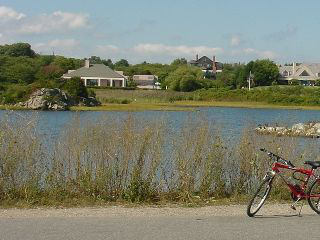

img2 size:(320, 240)


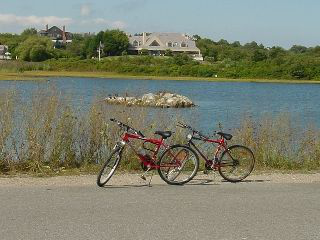

In [ ]:
# 画像入力

img1_url = pathlib.Path('images/sample_img1/Level1/1-001-1.jpg')
img2_url = pathlib.Path('images/sample_img1/Level1/1-001-2.jpg')

# 元となる画像の読み込み
img1 = Image.open(img1_url)
img2 = Image.open(img2_url)

print("img1 size:{}".format(img1.size))
display(img1)
print("img2 size:{}".format(img2.size))
display(img2)


## 画像ファイル配列化

[初めてのPython画像処理](https://qiita.com/uosansatox/items/4fa34e1d8d95d8783536)

## 照合

In [ ]:
dx = dy = 0
dt = 0.0
r  = 1.0 

# 時間測定開始
start = time.time()

# 照合(別ファイル)
dx, dy, dt, r = Mosaic.mosaic(img1, img2, r)

# 時間測定終了
elapsed_time = time.time() - start

print("dx:{}, dy:{}, dt:{} r:{}".format(dx, dy, dt, r))
print("time:{}".format(elapsed_time))


j_min1:30, i_min1:6, t_min:0.0
dx:150, dy:30, dt:0.0 r:1.0
time:75.1895432472229


## 出力画像の合成

In [ ]:
image3 = Pnm.construct_image(img1, img2, dx, dy, dt, 1.0)

#　表示
display(image3)
 
# 書き出し
# image3.save('')